# Kilter Board Climbing Analysis

Exploring climbing progression on the Kilter board from April 2025 to February 2026.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import numpy as np

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

## 1. Data Loading & Overview

In [30]:
df = pd.read_csv("output", parse_dates=["date"])
print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print()
df.dtypes

Shape: (133, 14)
Date range: 2025-04-09 to 2026-02-16



board                      object
angle                       int64
climb_name                 object
date               datetime64[ns]
logged_grade               object
displayed_grade            object
is_benchmark                 bool
tries                       int64
is_mirror                    bool
sessions_count              int64
tries_total                 int64
is_repeat                    bool
is_ascent                    bool
comment                   float64
dtype: object

In [31]:
df.head(10)

,board,angle,climb_name,date,logged_grade,displayed_grade,is_benchmark,tries,is_mirror,sessions_count,tries_total,is_repeat,is_ascent,comment
0,kilter,40,cchhhhooooccccoooolllaaatteee!!!,2025-04-09 00:00:00,NaN,5c/V2,False,6,False,1,6,False,False,NaN
1,kilter,40,Evan Williams,2025-04-09 09:32:17,5a/V1,5a/V1,False,1,False,1,1,False,True,NaN
2,kilter,40,Easy A,2025-04-09 09:34:05,4b/V0,4b/V0,False,1,False,1,1,False,True,NaN
3,kilter,40,She Crushes!,2025-04-09 09:35:42,5a/V1,5a/V1,False,1,False,1,1,False,True,NaN
4,kilter,40,BK Warm Up V1 - V2,2025-04-09 09:37:42,5a/V1,5a/V1,False,1,False,1,1,False,True,NaN
5,kilter,40,There will be blood 💉,2025-04-09 10:00:47,5c/V2,5b/V1,False,10,False,1,10,False,True,NaN
6,kilter,40,A-Thee A-Thee A-Thee That's All Folks,2025-04-09 10:19:04,5a/V1,5a/V1,False,15,False,1,15,False,True,NaN
7,kilter,40,Penguin feeds Bear,2025-04-09 10:20:21,4a/V0,4a/V0,False,1,False,1,1,False,True,NaN
8,kilter,40,Jugglin Holds,2025-04-14 00:00:00,NaN,5c/V2,False,5,False,1,5,False,False,NaN
9,kilter,40,cchhhhooooccccoooolllaaatteee!!!,2025-04-14 00:00:00,NaN,5c/V2,False,10,False,2,16,True,False,NaN


In [32]:
df.describe(include="all")

,board,angle,climb_name,date,logged_grade,displayed_grade,is_benchmark,tries,is_mirror,sessions_count,tries_total,is_repeat,is_ascent,comment
count,133,133.000000,133,133,114,133,133,133.000000,133,133.000000,133.000000,133,133,0.0
unique,1,NaN,66,NaN,10,11,2,NaN,1,NaN,NaN,2,2,NaN
top,kilter,NaN,Evan Williams,NaN,5a/V1,5a/V1,False,NaN,False,NaN,NaN,False,True,NaN
freq,133,NaN,10,NaN,28,29,97,NaN,133,NaN,NaN,70,114,NaN
mean,NaN,40.488722,NaN,2025-09-27 23:25:56.857142784,NaN,NaN,NaN,2.007519,NaN,2.315789,4.887218,NaN,NaN,NaN
min,NaN,40.000000,NaN,2025-04-09 00:00:00,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN
25%,NaN,40.000000,NaN,2025-05-12 10:38:42,NaN,NaN,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN
50%,NaN,40.000000,NaN,2025-09-08 09:54:09,NaN,NaN,NaN,1.000000,NaN,1.000000,3.000000,NaN,NaN,NaN
75%,NaN,40.000000,NaN,2026-01-26 00:00:00,NaN,NaN,NaN,2.000000,NaN,3.000000,6.000000,NaN,NaN,NaN
max,NaN,60.000000,NaN,2026-02-16 10:16:19,NaN,NaN,NaN,15.000000,NaN,10.000000,20.000000,NaN,NaN,NaN


## 2. Grade Parsing

Extract the V-grade number from `displayed_grade` (e.g. `6b/V4` -> `4`).

In [33]:
def parse_v_grade(grade_str):
    """Extract numeric V-grade from strings like '5c/V2', '6a+/V3'."""
    if pd.isna(grade_str):
        return np.nan
    m = re.search(r"V(\d+)", grade_str)
    return int(m.group(1)) if m else np.nan

df["v_grade"] = df["displayed_grade"].apply(parse_v_grade)
df["session_date"] = df["date"].dt.date

print("V-grade distribution:")
df["v_grade"].value_counts().sort_index()

V-grade distribution:


v_grade
0    20
1    40
2    20
3    28
4    19
5     6
Name: count, dtype: int64

## 3. Session Timeline

How often are you climbing? Sessions per week and month.

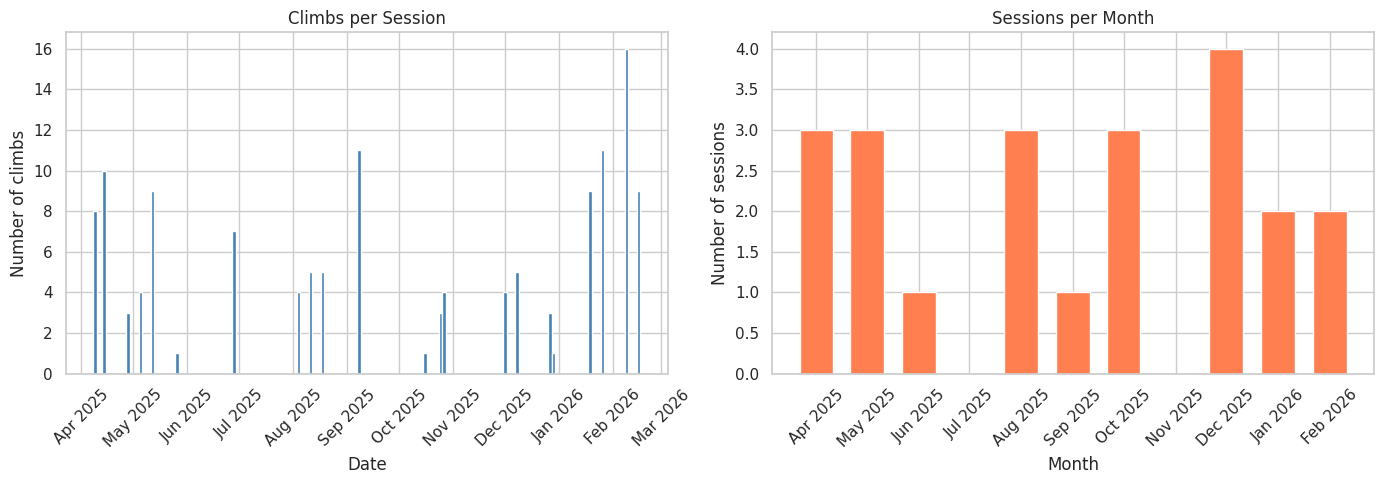

In [34]:
session_dates = df.groupby("session_date").size().reset_index(name="climbs")
session_dates["session_date"] = pd.to_datetime(session_dates["session_date"])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Climbs per session
axes[0].bar(session_dates["session_date"], session_dates["climbs"], width=2, color="steelblue")
axes[0].set_title("Climbs per Session")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Number of climbs")
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[0].tick_params(axis="x", rotation=45)

# Sessions per month
monthly = df.groupby(df["date"].dt.to_period("M"))["session_date"].nunique()
monthly.index = monthly.index.to_timestamp()
axes[1].bar(monthly.index, monthly.values, width=20, color="coral")
axes[1].set_title("Sessions per Month")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Number of sessions")
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

## 4. Grade Progression

Max and average V-grade sent per session over time, with trend lines.

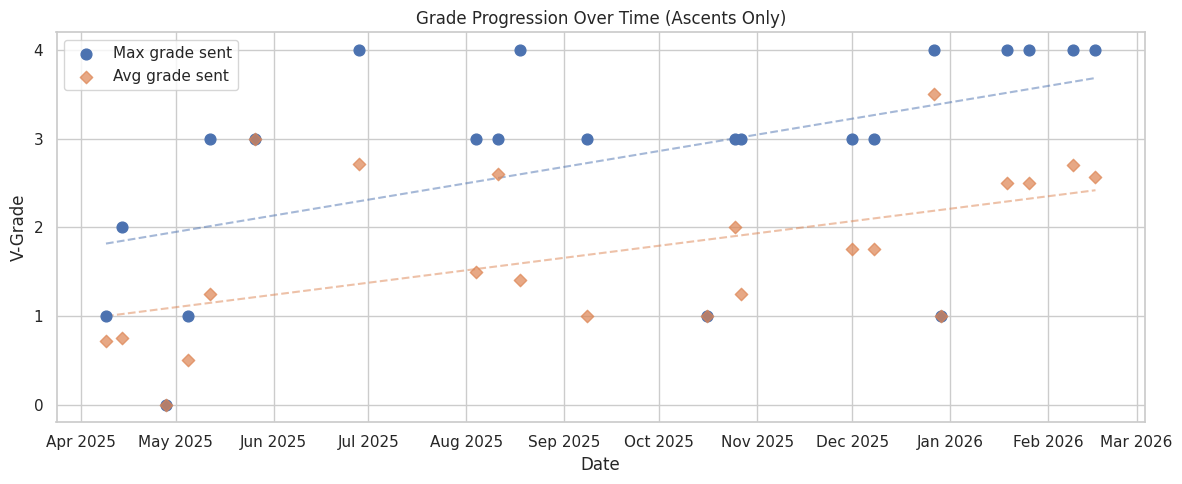

In [35]:
ascents = df[df["is_ascent"] == True].copy()

session_grades = ascents.groupby("session_date")["v_grade"].agg(["max", "mean"]).reset_index()
session_grades["session_date"] = pd.to_datetime(session_grades["session_date"])

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(session_grades["session_date"], session_grades["max"], label="Max grade sent", s=60, zorder=3)
ax.scatter(session_grades["session_date"], session_grades["mean"], label="Avg grade sent", s=40, marker="D", alpha=0.7, zorder=3)

# Trend lines
x_num = mdates.date2num(session_grades["session_date"])
for col, color in [("max", "C0"), ("mean", "C1")]:
    z = np.polyfit(x_num, session_grades[col], 1)
    p = np.poly1d(z)
    ax.plot(session_grades["session_date"], p(x_num), "--", color=color, alpha=0.5)

ax.set_title("Grade Progression Over Time (Ascents Only)")
ax.set_xlabel("Date")
ax.set_ylabel("V-Grade")
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.legend()
plt.tight_layout()
plt.show()

## 5. Send Rate

Ascent rate and flash rate (sent on first try), broken down by grade.

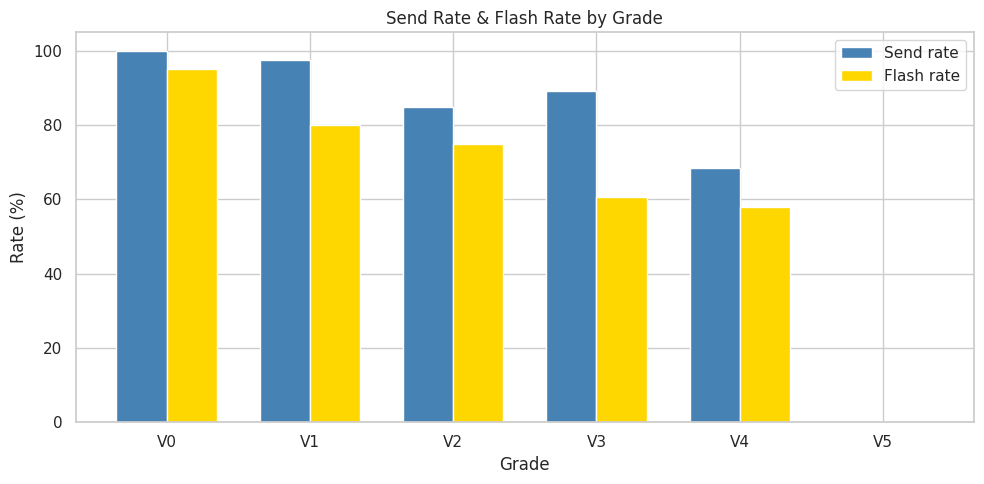

,v_grade,total,ascents,flashes,send_rate,flash_rate
0,0,20,20,19,1.000000,0.950000
1,1,40,39,32,0.975000,0.800000
2,2,20,17,15,0.850000,0.750000
3,3,28,25,17,0.892857,0.607143
4,4,19,13,11,0.684211,0.578947
5,5,6,0,0,0.000000,0.000000


In [36]:
grade_stats = df.groupby("v_grade").agg(
    total=pd.NamedAgg(column="is_ascent", aggfunc="count"),
    ascents=pd.NamedAgg(column="is_ascent", aggfunc="sum"),
).reset_index()

# Flash = ascent with tries == 1
flashes = df[(df["is_ascent"] == True) & (df["tries"] == 1)].groupby("v_grade").size().reset_index(name="flashes")
grade_stats = grade_stats.merge(flashes, on="v_grade", how="left").fillna(0)
grade_stats["flashes"] = grade_stats["flashes"].astype(int)

grade_stats["send_rate"] = grade_stats["ascents"] / grade_stats["total"]
grade_stats["flash_rate"] = grade_stats["flashes"] / grade_stats["total"]

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(grade_stats))
width = 0.35
ax.bar(x - width/2, grade_stats["send_rate"] * 100, width, label="Send rate", color="steelblue")
ax.bar(x + width/2, grade_stats["flash_rate"] * 100, width, label="Flash rate", color="gold")
ax.set_xticks(x)
ax.set_xticklabels([f"V{int(g)}" for g in grade_stats["v_grade"]])
ax.set_xlabel("Grade")
ax.set_ylabel("Rate (%)")
ax.set_title("Send Rate & Flash Rate by Grade")
ax.legend()
plt.tight_layout()
plt.show()

grade_stats

## 6. Tries Analysis

How many attempts does it take? Distribution and average by grade.

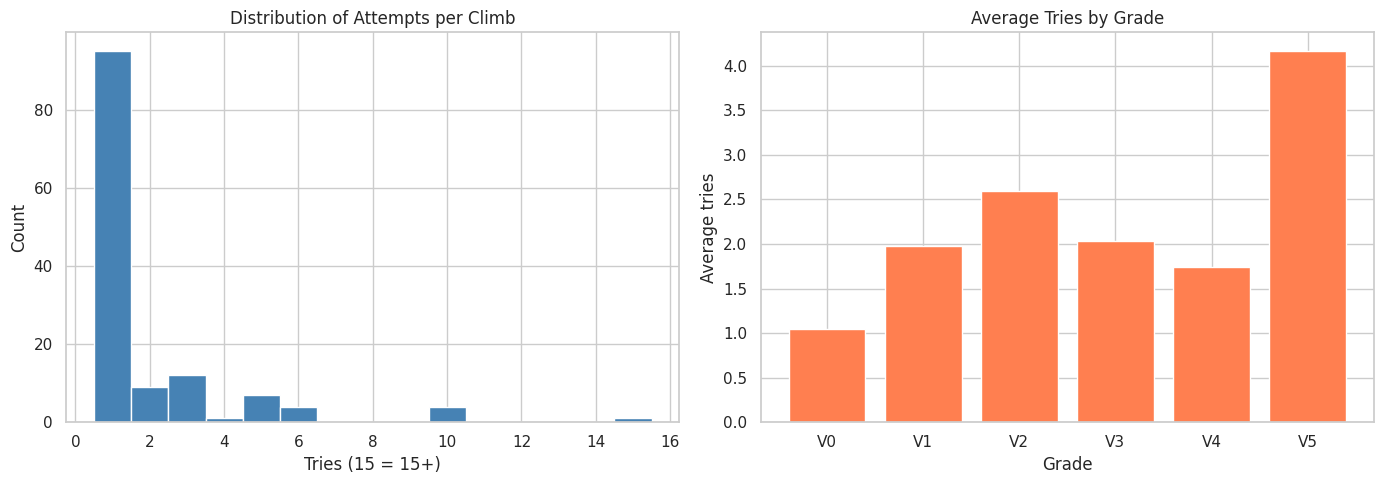

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of tries (capped at 15 for readability)
tries_capped = df["tries"].clip(upper=15)
axes[0].hist(tries_capped, bins=range(1, 17), edgecolor="white", color="steelblue", align="left")
axes[0].set_title("Distribution of Attempts per Climb")
axes[0].set_xlabel("Tries (15 = 15+)")
axes[0].set_ylabel("Count")

# Average tries by grade
avg_tries = df.groupby("v_grade")["tries"].mean()
axes[1].bar([f"V{int(g)}" for g in avg_tries.index], avg_tries.values, color="coral")
axes[1].set_title("Average Tries by Grade")
axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Average tries")

plt.tight_layout()
plt.show()

## 7. Most Climbed Routes

Top repeated climbs and total sessions per climb.

/tmp/ipykernel_1023302/112479828.py:17: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/danilo/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128137 (\N{SYRINGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


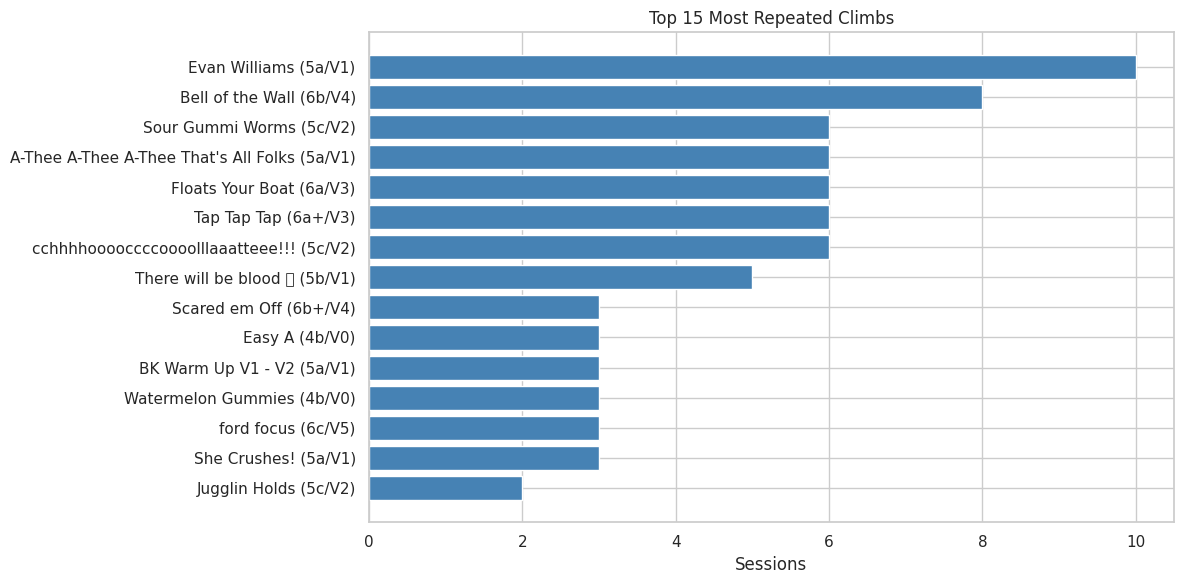

,sessions,total_logs,grade,ascents
climb_name,,,,
Evan Williams,10,10,5a/V1,10
Bell of the Wall,8,8,6b/V4,8
Sour Gummi Worms,6,6,5c/V2,6
A-Thee A-Thee A-Thee That's All Folks,6,6,5a/V1,6
Floats Your Boat,6,6,6a/V3,6
Tap Tap Tap,6,6,6a+/V3,6
cchhhhooooccccoooolllaaatteee!!!,6,6,5c/V2,4
There will be blood 💉,5,5,5b/V1,5
Scared em Off,3,3,6b+/V4,1


In [38]:
climb_counts = df.groupby("climb_name").agg(
    sessions=pd.NamedAgg(column="session_date", aggfunc="nunique"),
    total_logs=pd.NamedAgg(column="climb_name", aggfunc="count"),
    grade=pd.NamedAgg(column="displayed_grade", aggfunc="first"),
    ascents=pd.NamedAgg(column="is_ascent", aggfunc="sum"),
).sort_values("sessions", ascending=False)

top = climb_counts.head(15)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(range(len(top)), top["sessions"], color="steelblue")
ax.set_yticks(range(len(top)))
ax.set_yticklabels([f"{name} ({row['grade']})" for name, row in top.iterrows()])
ax.invert_yaxis()
ax.set_xlabel("Sessions")
ax.set_title("Top 15 Most Repeated Climbs")
plt.tight_layout()
plt.show()

climb_counts.head(15)

## 8. Benchmark Progress

Benchmark climbs sent over time, showing progression through the official benchmark set.

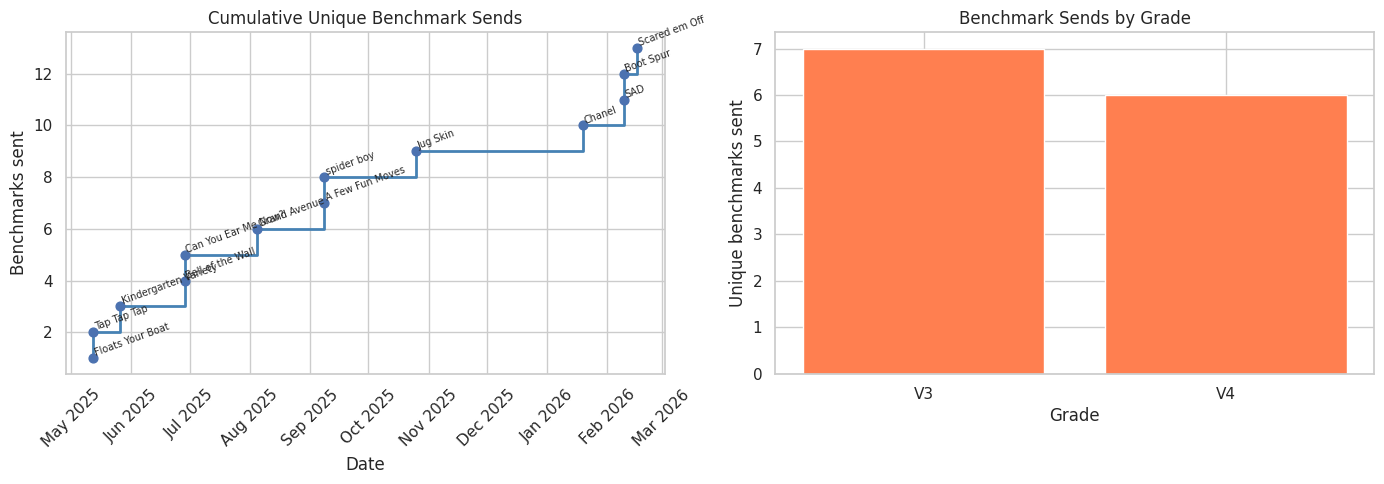

Total unique benchmarks sent: 13


,climb_name,displayed_grade,date,tries
32,Floats Your Boat,6a/V3,2025-05-12 10:33:33,1
33,Tap Tap Tap,6a+/V3,2025-05-12 10:38:42,2
34,Kindergarten Variety,6a/V3,2025-05-26 10:09:31,3
40,Bell of the Wall,6b/V4,2025-06-28 10:55:19,1
41,Can You Ear Me Now?,6b+/V4,2025-06-28 11:09:53,1
44,Grand Avenue,6a+/V3,2025-08-04 22:26:21,1
65,A Few Fun Moves,6a/V3,2025-09-08 09:50:18,1
66,spider boy,6a/V3,2025-09-08 09:54:09,3
70,Jug Skin,6a+/V3,2025-10-25 17:20:36,1
96,Chanel,6b+/V4,2026-01-19 10:17:33,1


In [39]:
benchmarks = df[df["is_benchmark"] == True].copy()
benchmark_ascents = benchmarks[benchmarks["is_ascent"] == True].copy()

# First ascent of each benchmark climb
first_sends = benchmark_ascents.sort_values("date").drop_duplicates(subset="climb_name", keep="first")
first_sends = first_sends.sort_values("date")
first_sends["cumulative"] = range(1, len(first_sends) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative benchmark sends
axes[0].step(first_sends["date"], first_sends["cumulative"], where="post", color="steelblue", linewidth=2)
axes[0].scatter(first_sends["date"], first_sends["cumulative"], zorder=3, s=40)
for _, row in first_sends.iterrows():
    axes[0].annotate(row["climb_name"], (row["date"], row["cumulative"]),
                     fontsize=7, rotation=20, ha="left", va="bottom")
axes[0].set_title("Cumulative Unique Benchmark Sends")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Benchmarks sent")
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
axes[0].tick_params(axis="x", rotation=45)

# Benchmark sends by grade
bench_grade = first_sends.groupby("v_grade").size()
axes[1].bar([f"V{int(g)}" for g in bench_grade.index], bench_grade.values, color="coral")
axes[1].set_title("Benchmark Sends by Grade")
axes[1].set_xlabel("Grade")
axes[1].set_ylabel("Unique benchmarks sent")

plt.tight_layout()
plt.show()

print(f"Total unique benchmarks sent: {len(first_sends)}")
first_sends[["climb_name", "displayed_grade", "date", "tries"]]

## 9. Angle Breakdown

How does performance vary across wall angles?

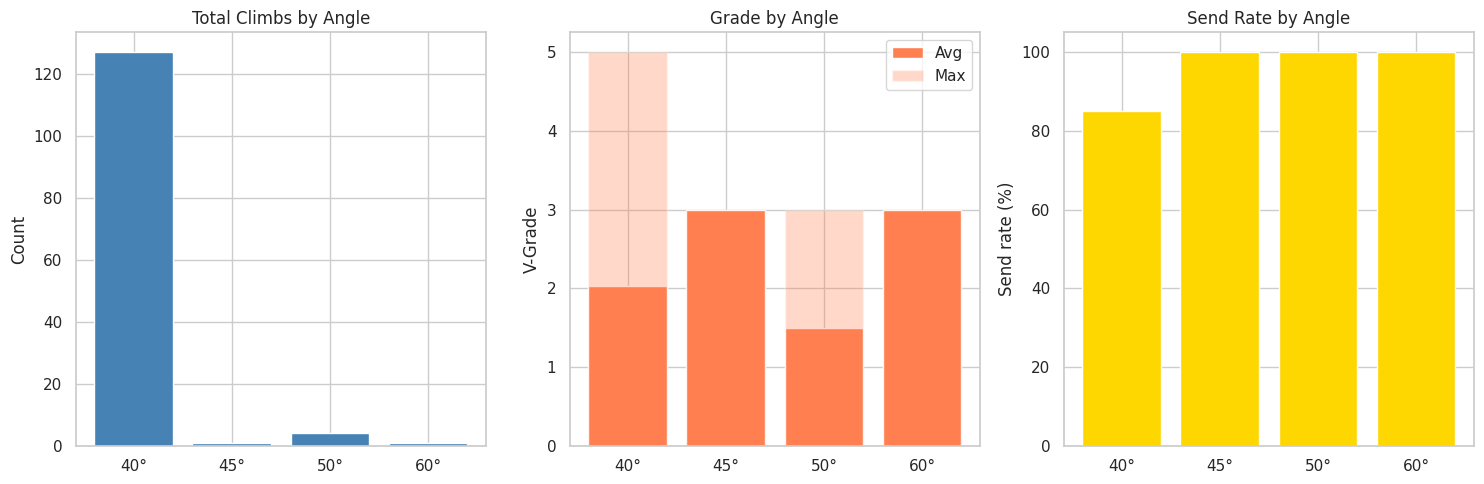

,angle,total_climbs,ascents,avg_grade,max_grade,avg_tries,send_rate
0,40,127,108,2.031496,5,2.03937,0.850394
1,45,1,1,3.000000,3,1.00000,1.000000
2,50,4,4,1.500000,3,1.00000,1.000000
3,60,1,1,3.000000,3,3.00000,1.000000


In [40]:
angle_stats = df.groupby("angle").agg(
    total_climbs=pd.NamedAgg(column="climb_name", aggfunc="count"),
    ascents=pd.NamedAgg(column="is_ascent", aggfunc="sum"),
    avg_grade=pd.NamedAgg(column="v_grade", aggfunc="mean"),
    max_grade=pd.NamedAgg(column="v_grade", aggfunc="max"),
    avg_tries=pd.NamedAgg(column="tries", aggfunc="mean"),
).reset_index()
angle_stats["send_rate"] = angle_stats["ascents"] / angle_stats["total_climbs"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

angles_label = [f"{a}°" for a in angle_stats["angle"]]

axes[0].bar(angles_label, angle_stats["total_climbs"], color="steelblue")
axes[0].set_title("Total Climbs by Angle")
axes[0].set_ylabel("Count")

axes[1].bar(angles_label, angle_stats["avg_grade"], color="coral", label="Avg")
axes[1].bar(angles_label, angle_stats["max_grade"], color="coral", alpha=0.3, label="Max")
axes[1].set_title("Grade by Angle")
axes[1].set_ylabel("V-Grade")
axes[1].legend()

axes[2].bar(angles_label, angle_stats["send_rate"] * 100, color="gold")
axes[2].set_title("Send Rate by Angle")
axes[2].set_ylabel("Send rate (%)")

plt.tight_layout()
plt.show()

angle_stats

## 10. Monthly Top-10 Points Score

Custom scoring system based on Font grade. Only ascents with grade 6a or above earn points.

| Font Grade | Base Points |
|------------|-------------|
| 6c         | 55          |
| 6b+        | 40          |
| 6b         | 30          |
| 6a+        | 22          |
| 6a         | 16          |

**Modifiers:** +10% flash bonus (tries = 1), −0.1 per attempt.

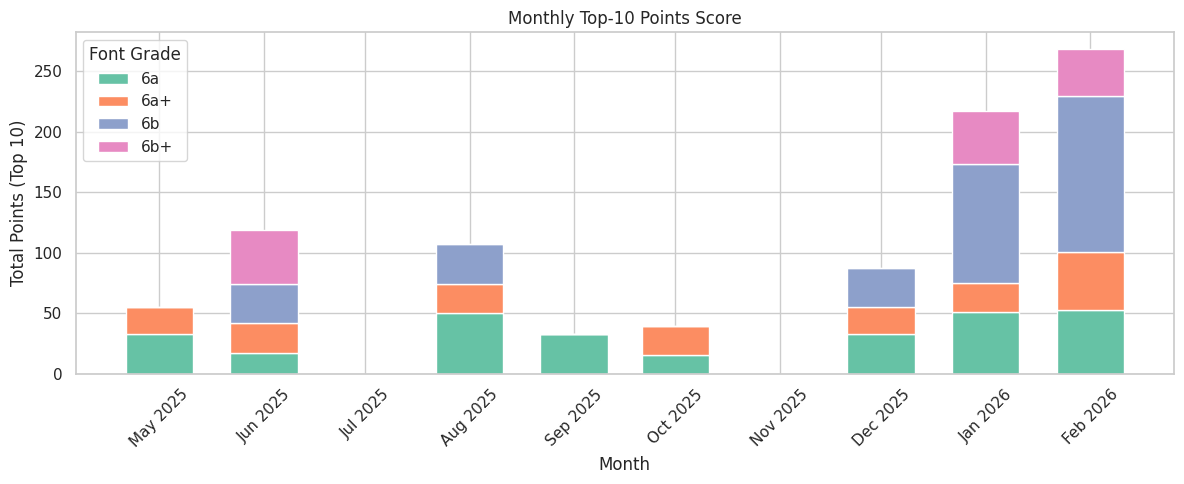


  2025-05  —  Top 3 ascents  —  Total: 55.0 pts
   1. Tap Tap Tap                         6a+   21.8 pts  (2 tries)
   2. Floats Your Boat                     6a   17.5 pts  (1 try) ⚡
   3. Kindergarten Variety                 6a   15.7 pts  (3 tries)

  2025-06  —  Top 4 ascents  —  Total: 118.4 pts
   1. Can You Ear Me Now?                 6b+   43.9 pts  (1 try) ⚡
   2. Bell of the Wall                     6b   32.9 pts  (1 try) ⚡
   3. Tap Tap Tap                         6a+   24.1 pts  (1 try) ⚡
   4. Floats Your Boat                     6a   17.5 pts  (1 try) ⚡

  2025-08  —  Top 5 ascents  —  Total: 107.4 pts
   1. Bell of the Wall                     6b   32.9 pts  (1 try) ⚡
   2. Grand Avenue                        6a+   24.1 pts  (1 try) ⚡
   3. YEET!!!!                             6a   17.5 pts  (1 try) ⚡
   4. YEET!!!!                             6a   17.5 pts  (1 try) ⚡
   5. Monkey Bread                         6a   15.4 pts  (6 tries)

  2025-09  —  Top 2 ascents  —  To

In [41]:
FONT_GRADE_POINTS = {
    "6c": 55,
    "6b+": 40,
    "6b": 30,
    "6a+": 22,
    "6a": 16,
}

GRADE_COLORS = {
    "6a": "#66c2a5",
    "6a+": "#fc8d62",
    "6b": "#8da0cb",
    "6b+": "#e78ac3",
    "6c": "#a6d854",
}

# Ordered from easiest to hardest for stacking
GRADE_ORDER = ["6a", "6a+", "6b", "6b+", "6c"]

def compute_points(row):
    font_grade = row["displayed_grade"].split("/")[0].lower()
    base = FONT_GRADE_POINTS.get(font_grade, 0)
    if base == 0:
        return 0.0
    flash_mult = 1.10 if row["tries"] == 1 else 1.0
    return base * flash_mult - row["tries"] * 0.1

scored = ascents.copy()
scored["font_grade"] = scored["displayed_grade"].str.split("/").str[0].str.lower()
scored["points"] = scored.apply(compute_points, axis=1)
scored["month"] = scored["date"].dt.to_period("M")

# Top 10 per month
top10 = (
    scored[scored["points"] > 0]
    .sort_values("points", ascending=False)
    .groupby("month")
    .head(10)
)

# Pivot: sum points per month per grade
pivot = top10.groupby(["month", "font_grade"])["points"].sum().unstack(fill_value=0)
pivot.index = pivot.index.to_timestamp()
# Ensure all grades present and in order
for g in GRADE_ORDER:
    if g not in pivot.columns:
        pivot[g] = 0.0
pivot = pivot[GRADE_ORDER]

# Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 5))
bottom = np.zeros(len(pivot))
for grade in GRADE_ORDER:
    vals = pivot[grade].values
    if vals.sum() > 0:
        ax.bar(pivot.index, vals, width=20, bottom=bottom,
               color=GRADE_COLORS[grade], label=grade)
        bottom += vals

ax.set_title("Monthly Top-10 Points Score")
ax.set_xlabel("Month")
ax.set_ylabel("Total Points (Top 10)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.tick_params(axis="x", rotation=45)
ax.legend(title="Font Grade")
plt.tight_layout()
plt.show()

# Table breakdown per month
for month, group in top10.groupby("month"):
    rows = group.sort_values("points", ascending=False)
    print(f"\n{'='*60}")
    print(f"  {month}  —  Top {len(rows)} ascents  —  Total: {rows['points'].sum():.1f} pts")
    print(f"{'='*60}")
    for i, (_, r) in enumerate(rows.iterrows(), 1):
        flash_tag = " ⚡" if r["tries"] == 1 else ""
        print(f"  {i:>2}. {r['climb_name']:<35} {r['font_grade']:>3}  "
              f"{r['points']:>5.1f} pts  ({r['tries']} {'try' if r['tries'] == 1 else 'tries'}){flash_tag}")

## Summary

Key stats at a glance.

In [42]:
total_sessions = df["session_date"].nunique()
total_ascents = df["is_ascent"].sum()
total_flashes = ((df["is_ascent"] == True) & (df["tries"] == 1)).sum()
unique_climbs = df["climb_name"].nunique()
max_grade = df.loc[df["is_ascent"] == True, "v_grade"].max()

print(f"Total sessions:          {total_sessions}")
print(f"Total logged climbs:     {len(df)}")
print(f"Total ascents:           {total_ascents}")
print(f"Flash count:             {total_flashes}")
print(f"Unique climbs attempted: {unique_climbs}")
print(f"Highest grade sent:      V{int(max_grade)}")
print(f"Overall send rate:       {total_ascents / len(df) * 100:.1f}%")
print(f"Overall flash rate:      {total_flashes / len(df) * 100:.1f}%")

Total sessions:          22
Total logged climbs:     133
Total ascents:           114
Flash count:             94
Unique climbs attempted: 66
Highest grade sent:      V4
Overall send rate:       85.7%
Overall flash rate:      70.7%
